Problem statement

Your task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages! 

### Import library

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel,XLMRobertaTokenizer, TFXLMRobertaModel
from tensorflow.keras.layers import GlobalAveragePooling1D
print(tf.__version__)

2.11.0


### Get files

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


### Silence warning

In [3]:
os.environ["WANDB_API_KEY"] = "0" 

### Set up TPU

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


### Read files

In [5]:
train = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")
submission = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/sample_submission.csv")

In [6]:
train.shape

(12120, 6)

In [7]:
test

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


### Analyse train

In [8]:
train['label'].value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

### Analyse test

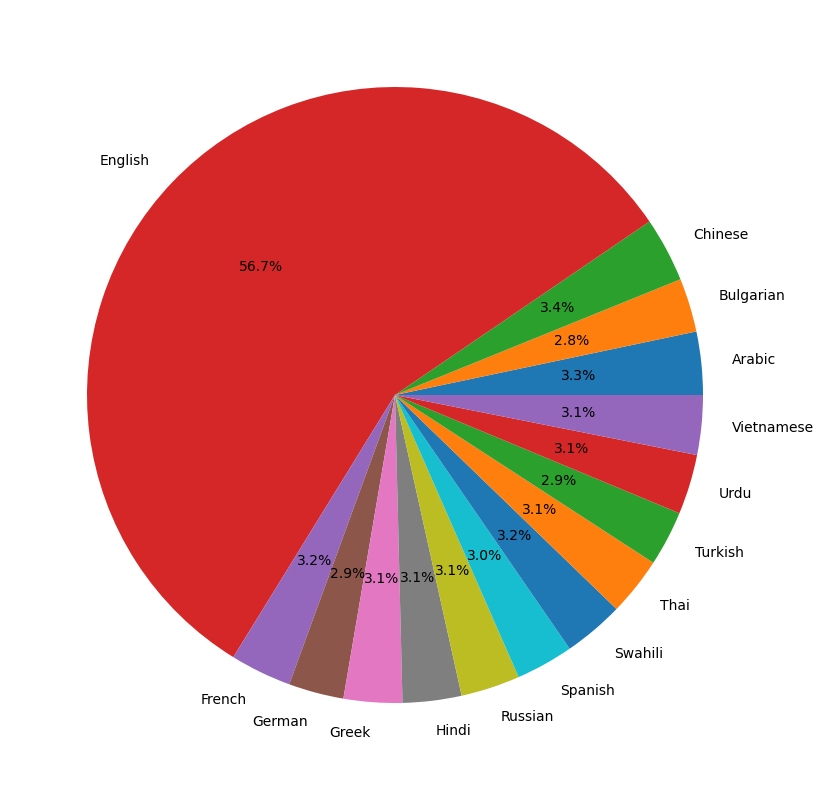

In [9]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

### Prepare data for model

In [10]:
model_name = 'xlm-roberta-base'
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

In [11]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [12]:
encode_sentence("Machine learning is fun!")


[68311, 52080, 83, 7477, 38, 3]

In [13]:
def bert_encode( premises,hypothesis,tokenizer):
    
    num_examples = len(hypothesis)

    sentence1 = tf.ragged.constant([
        encode_sentence(s)
        for s in np.array(hypothesis)])
    sentence2 = tf.ragged.constant([
        encode_sentence(s)
        for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [14]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)


### Define model

In [15]:
from tensorflow.keras import regularizers


In [16]:
def build_model():
    bert_encoder = TFXLMRobertaModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    dropout = tf.keras.layers.Dropout(0.3)(embedding[:,:,:])
    features = GlobalAveragePooling1D()(dropout)
   
    output = tf.keras.layers.Dense(
        3, activation='softmax', 
        kernel_regularizer=regularizers.l2(0.01),
        bias_regularizer=regularizers.l2(0.01)
    )(features)
    
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [17]:
with strategy.scope():
    model = build_model()
    model.summary()

All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tfxlm_roberta_model (TFXLMRobe  TFBaseModelOutputWi  278043648  ['input_word_ids[0][0]',         
 rtaModel)                      thPoolingAndCrossAt               'input_mask[0][0]',         

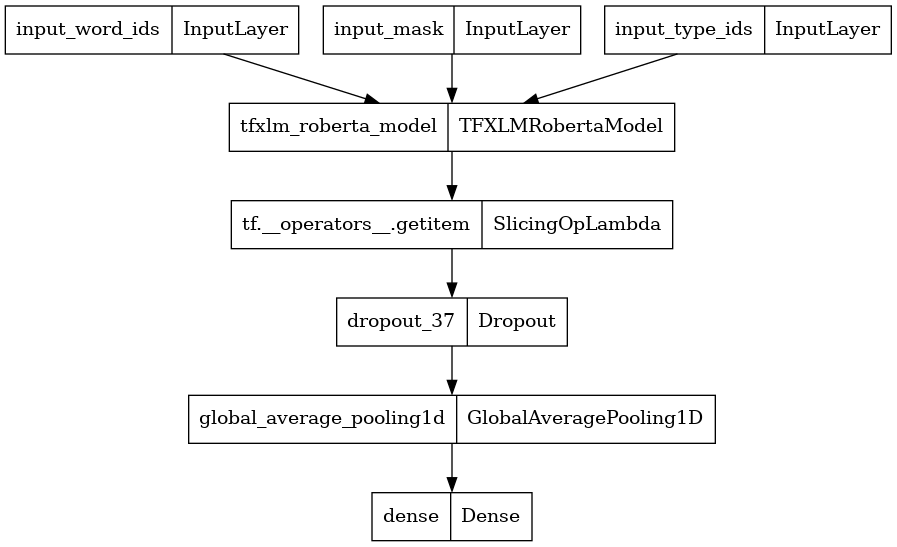

In [18]:
keras.utils.plot_model(model, "statement_classifier.png")

In [19]:
model.fit(train_input, train.label.values, epochs =5, verbose = 1, batch_size = 8, validation_split = 0.2)

Epoch 1/5
1212/1212 [==============================] - 670s 522ms/step - loss: 0.9867 - accuracy: 0.5497 - val_loss: 0.8185 - val_accuracy: 0.6770
Epoch 2/5
1212/1212 [==============================] - 631s 520ms/step - loss: 0.7296 - accuracy: 0.7167 - val_loss: 0.7707 - val_accuracy: 0.6980
Epoch 3/5
1212/1212 [==============================] - 630s 520ms/step - loss: 0.5424 - accuracy: 0.8050 - val_loss: 0.8780 - val_accuracy: 0.6828
Epoch 4/5
1212/1212 [==============================] - 630s 520ms/step - loss: 0.3960 - accuracy: 0.8730 - val_loss: 0.8943 - val_accuracy: 0.7059
Epoch 5/5
1212/1212 [==============================] - 630s 520ms/step - loss: 0.2850 - accuracy: 0.9168 - val_loss: 1.0594 - val_accuracy: 0.7096


### Evaluate the model

In [20]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [21]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
predictions = np.array(predictions)
predictions = np.ndarray.flatten(predictions)
predictions

163/163 [==============================] - 93s 554ms/step


array([2, 1, 0, ..., 0, 0, 2])

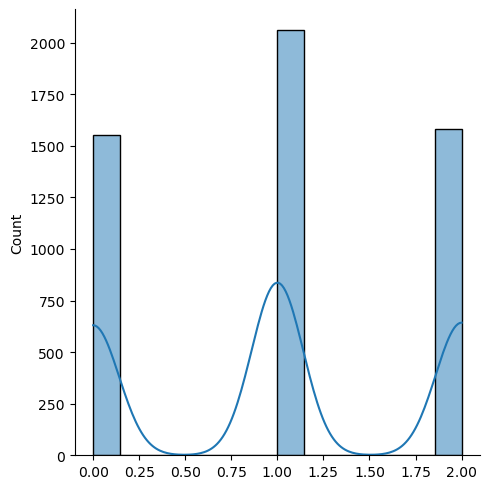

In [22]:
sns.displot(predictions, kde=True)

### Prepare submission

In [23]:
#submission['prediction'] = predictions
submission.to_csv('submission.csv',index=False) # writing data to a CSV file
submission = pd.read_csv("submission.csv")
submission

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,1
5192,1f0ea92118,1
5193,0407b48afb,1
